 # Factor Digging

In [3]:
import os
import pandas as pd
import numpy as np
from math import ceil
from tqdm import tqdm
from dask.multiprocessing import get

 ## Data Preparation

In [4]:
kline_min_dir = '../data/kline-min/'
kline_day_path = '../data/kline-daily/market-daily.parquet'
feature_dir = '../data/features/'
klines = pd.read_parquet(kline_day_path)

 ## Momentum

 ### Simple Mometum

 equals to the return in a period

In [ ]:
def momentum(close_price: pd.Series, period: int) -> pd.DataFrame:
    factor = close_price.groupby(level=1).pct_change(periods=period).dropna()
    return factor.unstack()

# momentum_5d = momentum(klines.adjclose, 5)
# momentum_5d.to_parquet(feature_dir + 'momentum_5d.parquet')
# momentum_10d = momentum(klines.adjclose, 10)
# momentum_10d.to_parquet(feature_dir + "momentum_10d.parquet")
# momentum_20d = momentum(klines.adjclose, 20)
# momentum_20d.to_parquet(feature_dir + "momentum_20d.parquet")

 ### Turover Weighted Momentum

 Daily return weighted by turnover of each day

In [ ]:
turnover = pd.read_parquet('../data/derivative-indicators/turnover.parquet')

In [ ]:
def wgt_momentum(turnover: pd.Series, close_price: pd.Series, period: int):
    ret = close_price.groupby(level=1).pct_change(1)
    factor = (turnover * ret).groupby(level=1).rolling(period).sum()
    return factor.droplevel(0).unstack().dropna(how='all')

wgt_momentum_5d = wgt_momentum(turnover.today, klines.adjclose, 5)
wgt_momentum_5d.to_parquet(feature_dir + 'wgt_momentum_5d.parquet')


 ### Exponential Turnover Weighted Momentum

 Equals to the $ \Sigma_{t=T-period}^{T} turnover_t * {dailyreturn}_t * exp^{- \frac{T - t} {N * 4}}$, where t represents the cross section date, T is the calculating date and N is total time period.

In [ ]:
turnover = pd.read_parquet('../input/derivative-indicators/turnover.parquet')

In [ ]:
def exp_wgt_momentum(turnover: pd.Series, close_price: pd.Series, period: int):
    def _calc(x):
        return (x * np.exp(-np.arange(period) / (4 * period))[::-1]).sum()
        
    ret = close_price.groupby(level=1).pct_change(1)
    factor = (turnover * ret).groupby(level=1).rolling(period, min_periods=period).apply(_calc)
    return factor.droplevel(0).dropna().unstack()

# exp_wgt_momentum_5d = exp_wgt_momentum(turnover.today, klines.adjclose, 5)
# exp_wgt_momentum_5d.to_parquet(feature_dir + 'exp_wgt_momentum_5d.parquet')

 ## Turnover

 ### Simple Turnover

 Equals to the turnover in a period

In [ ]:
# turnover = pd.read_parquet('../input/derivative-indicators/turnover.parquet')

In [ ]:
def turnover_(turnover: pd.Series, period: int):
    factor = turnover.groupby(level=1).rolling(period).mean()
    return factor.droplevel(0).dropna().unstack()

# turnover_5d = turnover_(turnover.today, period=5)
# turnover_5d.to_parquet(feature_dir + 'turnover_5d.parquet')

 ### Turnover Standard Deviation

 The standard deviation of turnover in a period

In [ ]:
def std_turnover(turnover: pd.Series, period: int):
    factor = turnover.groupby(level=1).rolling(period).std()
    return factor.droplevel(0).dropna().unstack()

# std_turnover_5d = std_turnover(turnover.today, period=5)
# std_turnover_5d.to_parquet(feature_dir + 'std_turnover_5d.parquet')

 ### Turnover Trend

 The moving average of turnover in a short period over a longer period

In [ ]:
def trend_turnover(turnover: pd.Series, short: int, long: int):
    short_turn = turnover.groupby(level=1).rolling(short).mean()
    long_turn = turnover.groupby(level=1).rolling(long).mean()
    factor = short_turn / long_turn - 1
    return factor.droplevel(0).dropna().unstack()

# trend_turnover_5d_10d = trend_turnover(turnover.today, 5, 10)
# trend_turnover_5d_10d.to_parquet(feature_dir + 'trend_turnover_5d_10d.parquet')


 ### Turnover Standard Deviation Trend

 The moving average of turnover deviation in a short period over a longer period

In [ ]:
def trend_deviation_turnover(turnover: pd.Series, short: int, long: int):
    short_turn = turnover.groupby(level=1).rolling(short).std()
    long_turn = turnover.groupby(level=1).rolling(long).std()
    factor = short_turn / long_turn - 1
    return factor.droplevel(0).dropna().unstack()

# trend_deviation_turnover_5d_10d = trend_deviation_turnover(turnover.today, 5, 10)
# trend_deviation_turnover_5d_10d.to_parquet(feature_dir + 'trend_deviation_turnover_5d_10d.parquet')

 ## Volatility

 ### Return Deviation

 The deviation of daily return in a period

In [44]:
def ret_deviation(close_price: pd.Series, period: int):
    ret = close_price.groupby(level=1).pct_change(1)
    factor = ret.groupby(level=1).rolling(period).std()
    return factor.droplevel(0).dropna().unstack()

ret_deviation_5d = ret_deviation(klines.adjclose, 5)
ret_deviation_5d.to_parquet(feature_dir + 'ret_deviation_5d.parquet')

## Capital Flow

In [11]:
lgt = pd.read_parquet('../data/derivative-indicators/hsg_holding.parquet')

### Lu Gu Tong momentum

In [21]:
def lgt_momentum(holding: pd.DataFrame, period: int = 5):
    factor = holding.pct_change(period)
    return factor

lgt_momentum_5d = lgt_momentum(lgt.shares_holding.unstack(level=0), period=5)
lgt_momentum_5d.astype('float32').to_parquet(feature_dir + 'lgt_momentum_5d.parquet')

### Lu Gu Tong holdings

In [16]:
def lgt_change(holding: pd.Series, period: int = 5):
    factor = holding.rolling(period).apply(
        lambda x: (x.iloc[-1] - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)
    return factor.dropna(how='all')

lgt_change_20d = lgt_change(lgt.shares_holding.unstack(level=0), 20)
lgt_change_20d.astype('float32').to_parquet(feature_dir + 'lgt_change_20d.parquet')

order_book_id,000001.XSHE,000002.XSHE,000005.XSHE,000006.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,000012.XSHE,000016.XSHE,...,688526.XSHG,688536.XSHG,688556.XSHG,688568.XSHG,688598.XSHG,688599.XSHG,688696.XSHG,688699.XSHG,688777.XSHG,688981.XSHG
trading_date,,,,,,,,,,,,,,,,,,,,,
2016-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,0.0,0.021749,0.0,0.0,0.761213,0.490996,NaN,0.0,0.214056,0.000000,...,0.040127,0.000000,1.0,0.018122,0.483619,1.0,1.000000,0.612372,1.000000,0.992159
2022-08-06,0.0,0.028233,0.0,0.0,0.761213,0.490996,NaN,0.0,0.214056,0.000000,...,0.044213,0.000000,1.0,0.018122,0.506304,1.0,1.000000,0.599844,1.000000,0.992159
2022-08-08,0.0,0.000000,0.0,0.0,0.727831,0.474221,NaN,0.0,0.592885,0.564233,...,0.000000,0.055411,1.0,0.000000,0.387063,1.0,0.922289,0.000000,0.909177,0.985565


 ## Minute Data Factor

### Minute Price correlation with Volume

Equals to the correlation coeficient of minute price and volume

In [3]:
dates = list(filter(lambda x: x.endswith('.parquet'), os.listdir(kline_min_dir)))

In [18]:
def pvcorr(data_path: str):
    data = pd.read_parquet(data_path, columns=['volume', 'adjclose'])
    factor = data.groupby(level=0).apply(
        lambda x: x.droplevel(0).groupby(
            lambda y: y.date).apply(
                lambda z: z['adjclose'].corr(z['volume'])))
    return factor

dsk = dict(zip([date[:6] for date in dates], [(pvcorr, kline_min_dir + date) for date in dates]))
chunck_size = 20
all_keys = list(dsk.keys())
results = get(dsk, all_keys)

In [41]:
nresults = []
for result in results:
    if len(result.shape) == 1:
        result = result.unstack(level=0)
    elif len(result.shape) == 2:
        result = result.T
    nresults.append(result)
nresults = pd.concat(nresults, axis=0)
nresults = nresults.dropna(axis=1, how='all')
nresults.index = pd.to_datetime(nresults.index)
nresults = nresults.sort_index()
nresults.astype('float32').to_parquet(feature_dir + 'pvcorr_1d.parquet')

 ## Factor Test
 First calculate the forward return:

 Suppose we are on day *T*, and after the end of the trading hours, we
 can calculate factor values, and use the value to select stock.
 So the fastest time we can buy the stock is the open price of the
 next day.

 Suppose we hold the stock for *period* days, so, on day *T + 1 + period*
 we sell the stock at the close.
 In conclusion, the way we calculate the forward return is:

 $ close_{T + 1 + period} / open_{T + 1} - 1 $

In [53]:
start = "2010-01-04"
end = "2022-01-04"
factor_name = 'ret_deviation_5d'

In [54]:
period = 1
forward = klines.adjclose.groupby(level=1).shift(-1 - period) / klines.adjopen.groupby(level=1).shift(-1) - 1
forward = forward.dropna().unstack()
forward = forward.loc[start:end]
forward.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688382.XSHG,301306.XSHE,001258.XSHE,688253.XSHG,301269.XSHE,603201.XSHG,688130.XSHG,301195.XSHE,301333.XSHE,688371.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.035790,-0.014272,0.0,0.021848,-0.026079,0.036023,0.0,-0.031221,-0.007621,-0.024529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.025806,-0.006763,0.0,-0.048939,-0.004634,-0.026499,0.0,0.017991,-0.030148,-0.016551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.013100,-0.000965,0.0,-0.023218,0.013825,-0.018156,0.0,0.079502,-0.023018,0.001964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.004445,-0.009728,0.0,0.003449,0.000935,0.018731,0.0,0.032710,0.034978,0.045954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,-0.044681,-0.021863,0.0,0.038983,0.000000,0.015626,0.0,-0.002641,0.017125,0.044878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ### Factor Preprocess
 When we are processing data, we applied deextreme and standarization.
 We didn't apply empty value process because we will stack and dropna automatically

In [57]:
factor = pd.read_parquet(feature_dir + factor_name + '.parquet')
factor = factor.loc[start:end]

factor_med = factor.median(axis=1)
mad = factor.subtract(factor_med, axis=0).abs().median(axis=1)

factor = factor.clip(factor_med - 9 * mad, factor_med + 9 * mad, axis=0)
factor = factor.subtract(factor.mean(axis=1), axis=0).divide(factor.std(axis=1), axis=0)

 ### Cross Section Plot

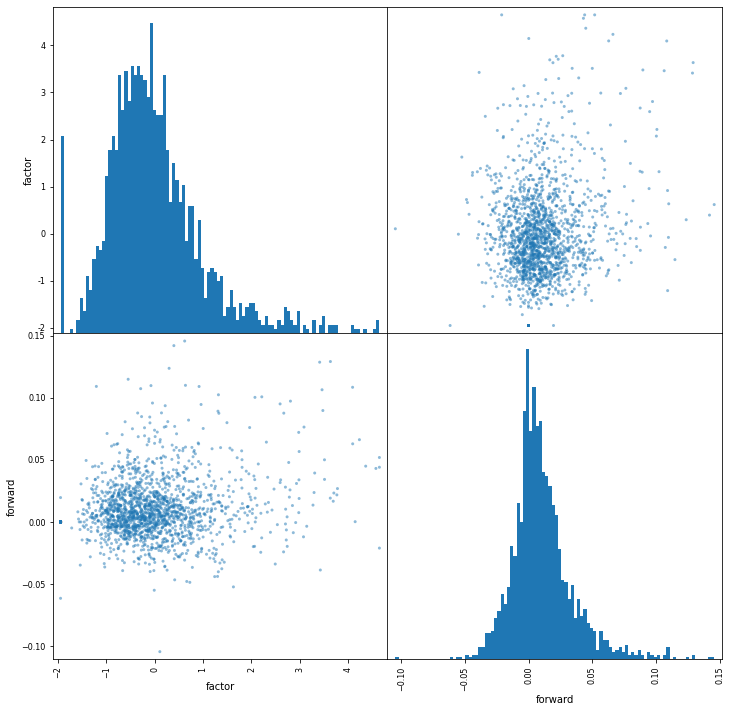

In [58]:
from pandas.plotting import scatter_matrix

common_index = factor.index.intersection(forward.index)
cross_section_period = common_index[23]

concated = pd.concat([factor.loc[cross_section_period], forward.loc[cross_section_period]], axis=1)
concated.columns = ['factor', 'forward']
_ = scatter_matrix(concated, figsize=(12, 12), hist_kwds={'bins': 100})


 ### IC Analyze

In [59]:
from scipy.stats import ttest_1samp

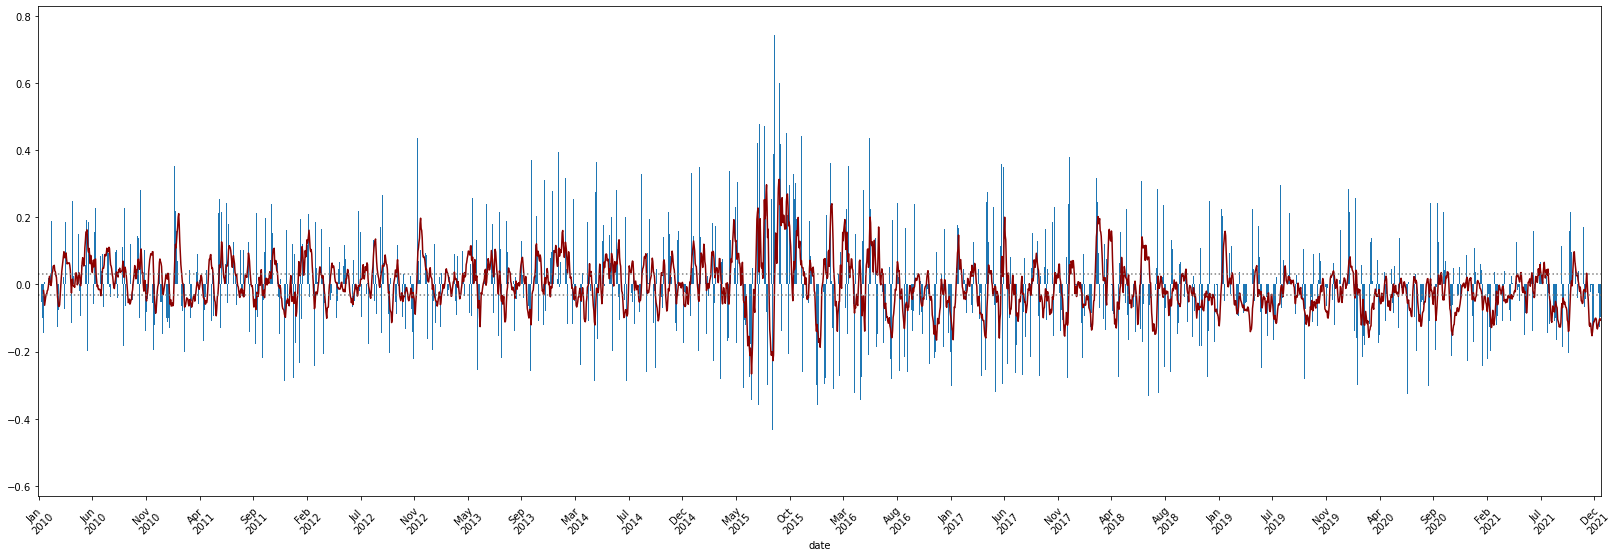

In [60]:
ic = factor.corrwith(forward, axis=1, method='spearman').dropna()
ax = ic.plot.bar(figsize=(28, 9))
ax.set_xticks(ax.get_xticks()[::100])
ax.plot(ic.rolling(10).mean().values, color='darkred')
_ = ax.set_xticklabels(ic.index.strftime('%b\n%Y')[::100], rotation=45)
ax.hlines(y=-0.03, xmax=ax.get_xlim()[-1], xmin=ax.get_xlim()[0], color='grey', linestyle=":")
ax.hlines(y=0.03, xmax=ax.get_xlim()[-1], xmin=ax.get_xlim()[0], color='grey', linestyle=':')

<AxesSubplot:xlabel='date'>

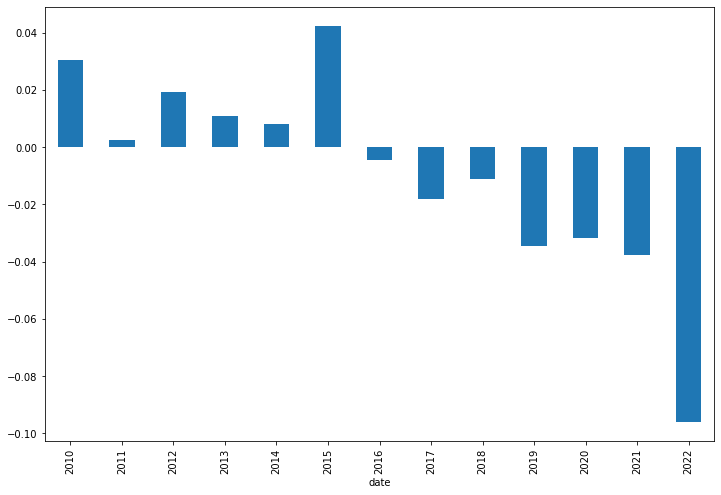

In [61]:
ic.groupby(lambda x: x.year).mean().plot.bar(figsize=(12, 8))

In [62]:
ic.mean(), ic.std(), ic.mean() / ic.std()

(-0.0021846776396091316, 0.16934699874557, -0.012900598509522044)

In [63]:
ttest_1samp(ic, 0)

Ttest_1sampResult(statistic=-0.6962738773399512, pvalue=0.486312898698562)

 ### Layering Test
 In layering test, we quantilize the factor into multiple group by
 its value, and hold the group as a portfolio to see the performance

In [65]:
# quantilize the factor data
quantiles = factor.stack().groupby(level=0).apply(pd.qcut, q=5, labels=False) + 1
quantiles = quantiles.loc[quantiles.unstack().index.intersection(forward.index)]

 Construct a portfolio by quantiles, `weights` is the normalized weight.
 And then calculate profit for each quantile, in the group of each quantile,
 we calculate return day by day, however, due to the influence of
 relocation period, we should split our money into period quantiles too

In [66]:
weights = pd.Series(np.ones_like(quantiles), index=quantiles.index)
weights = weights.groupby([quantiles, pd.Grouper(level=0)]).apply(lambda x: x / x.sum() * 1 / (period + 1) )

In [67]:
profit = weights.groupby([quantiles, pd.Grouper(level=0)]).apply(
    lambda x: (x * forward.loc[x.index.get_level_values(0)[0]]).sum()
)
profit = pd.concat([profit.unstack(level=0), forward.mean(axis=1) * 1 / (1 + period)], axis=1)
profit.columns = profit.columns[:-1].to_list() + ['simple_buy_hold']

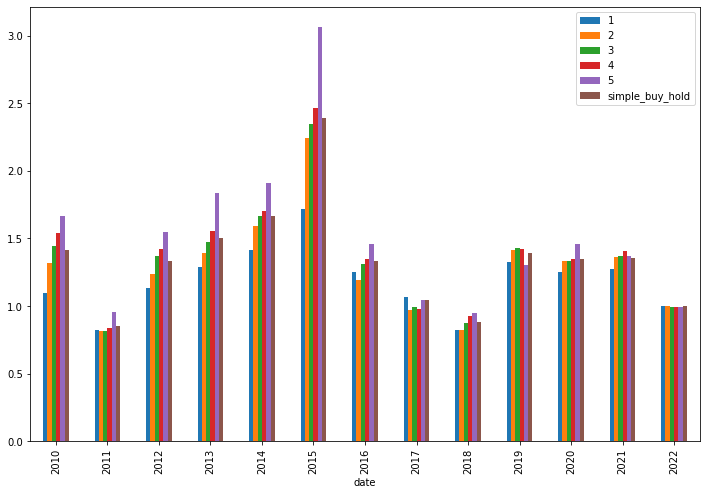

In [68]:
# The mean factor returns in each quantile
ax = profit.groupby(lambda x: x.year).apply(lambda x: (x + 1).cumprod().iloc[-1]).plot.bar(figsize=(12, 8))

 Trade by a high frequency, the trading
 commision cannot be neglected, here is how to
 calculate the turnover rate and add commisions
 on both sides (buy and sell)

In [69]:
panel_weights = weights.unstack().stack(dropna=False).fillna(0)
turnovers = []
for i in range(period + 1):
    subport_date = panel_weights.index.levels[0][i::(period + 1)]
    turnover = panel_weights.loc[subport_date].groupby(quantiles).apply(
        lambda x: (x - x.groupby(level=1).shift(1).fillna(0))\
            .groupby(level=0).apply(lambda y: y.abs().sum()
        )
    )
    turnovers.append(turnover)
turnover = pd.concat(turnovers, axis=0).sort_index()
turnover = turnover.unstack(level=0)
turnover = pd.concat([turnover, pd.Series(np.zeros(turnover.shape[0]), 
    index=turnover.index, name='simple_buy_hold')], axis=1)

Now we subtract the commision from the original profit,
and we set the commision rate to 0.003

In [70]:
commission_ratio = 0.003
profit -= commission_ratio * turnover
cumprofit = (profit.shift(period + 1).fillna(0) + 1).cumprod()

<AxesSubplot:xlabel='date'>

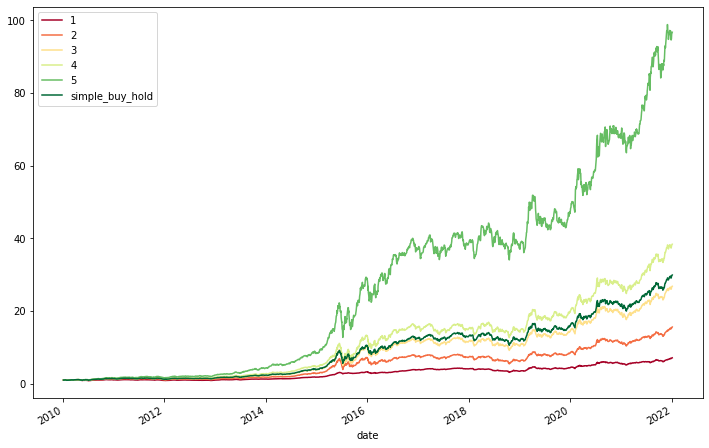

In [71]:
cumprofit.plot(figsize=(12, 8), cmap='RdYlGn')

<AxesSubplot:xlabel='date', ylabel='Turnover%'>

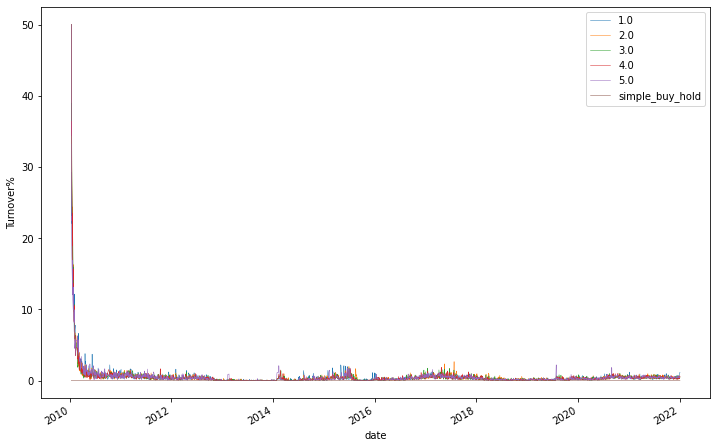

In [72]:
(turnover * 100).plot(figsize=(12, 8), ylabel='Turnover%', linewidth=0.5)